In [1]:
# Requires that Python, AzureMLSDK, Pandas, and NumPy are already installed
import azureml.core
import pandas as pd
import numpy as np
import logging

print("AzureML SDK Version:", azureml.core.VERSION)

AzureML SDK Version: 1.13.0


In [2]:
from azureml.core import Workspace, Experiment

# Requires that you download your config.json file from Azure Machine Learning to this folder
ws = Workspace.from_config()

# Can be named anything
experiment_name = "automl_bikeshare_forecast"

# This line will have output that requires you authenticate with Azure in the browser
experiment = Experiment(ws, experiment_name)

In [3]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

amlcompute_cluster_name = "cpu-cluster"
provisioning_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2",max_nodes=2)

compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)

compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=10)

Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [4]:
datastore = ws.get_default_datastore()

# Requires the bike-no.csv file in this folder
datastore.upload_files(files = ['bike-no.csv'], target_path='dataset/', overwrite=True, show_progress=True)

Uploading an estimated of 1 files
Uploading bike-no.csv
Uploaded bike-no.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_3d3c6b52c5e849e386ed1b1086cce065

In [5]:
from azureml.core import Dataset
from datetime import datetime

time_column_name = 'date'
target_column_name = 'cnt'
max_horizon = 14

dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'dataset/bike-no.csv')]).with_timestamp_columns(fine_grain_timestamp=time_column_name)

dataset.take(5).to_pandas_dataframe().reset_index(drop=True)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,6,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,2,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,3,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
#take 75% of the data leaving 25% for training
train = dataset.time_before(datetime(2012,8,31), include_boundary=True)
train.to_pandas_dataframe().tail(5).reset_index(drop=True)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,605,2012-08-27,3,1,8,1,1,0.703333,0.654688,0.730417,0.128733,989,5928,6917
1,606,2012-08-28,3,1,8,2,1,0.728333,0.666050,0.620000,0.190925,935,6105,7040
2,607,2012-08-29,3,1,8,3,1,0.685000,0.635733,0.552083,0.112562,1177,6520,7697
3,608,2012-08-30,3,1,8,4,1,0.706667,0.652779,0.590417,0.077117,1172,6541,7713
4,609,2012-08-31,3,1,8,5,1,0.764167,0.689400,0.587500,0.168533,1433,5917,7350


In [7]:
#25% for training
test = dataset.time_after(datetime(2012,9,1), include_boundary=True)
test.to_pandas_dataframe().head(5).reset_index(drop=True)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,610,2012-09-01,3,1,9,6,2,0.753333,0.702654,0.638333,0.113187,2352,3788,6140
1,611,2012-09-02,3,1,9,0,2,0.696667,0.649000,0.815000,0.064071,2613,3197,5810
2,612,2012-09-03,3,1,9,1,1,0.707500,0.661629,0.790833,0.151121,1965,4069,6034
3,613,2012-09-04,3,1,9,2,1,0.725833,0.686888,0.755000,0.236321,867,5997,6864
4,614,2012-09-05,3,1,9,3,1,0.736667,0.708983,0.741250,0.187808,832,6280,7112


In [8]:
from azureml.train.automl import AutoMLConfig

time_series_settings = {
    'time_column_name': time_column_name,
    'max_horizon': 14,
    'country_or_region': 'UK',
    'target_lags': 'auto',
    'drop_column_names': ['casual', 'registered']
}

automl_config = AutoMLConfig(task='forecasting',
                            primary_metric='normalized_root_mean_squared_error',
                            blacklist_models=['ExtremeRandomTrees'],
                            experiment_timeout_minutes=30,
                            training_data=train,
                            label_column_name=target_column_name,
                            compute_target=compute_target,
                            enable_early_stopping=True,
                            n_cross_validations=3,
                            max_concurrent_iterations=4,
                            max_cores_per_iteration=-1,
                            verbosity=logging.INFO,
                            **time_series_settings)

WARNING - Parameter 'blacklist_models' will be deprecated. Use 'blocked_models'


In [9]:

remote_run = experiment.submit(automl_config, show_output=False)
remote_run

Running on remote or ADB.


Experiment,Id,Type,Status,Details Page,Docs Page
automl_bikeshare_forecast,AutoML_89f7cda6-ff97-4bdb-b255-aeffd971a295,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [10]:
remote_run.wait_for_completion()

{'runId': 'AutoML_89f7cda6-ff97-4bdb-b255-aeffd971a295',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-09-12T10:30:42.749902Z',
 'endTimeUtc': '2020-09-12T10:48:59.565384Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl_bikeshare_forecast","subscription_id":"8901ed04-6fb1-4777-a541-382777c05b66","resource_group":"DevIntroDS_RG","workspace_name":"DevIntroDs","region":"uksouth","compute_target":"cpu-cluster","spark_service":null,"azure_service":"remote","_local_managed_run_id":null,"many_models":false,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_validations":3,"y_min":null,"y_max"

In [12]:
# Connect to the compute cluster again
amlcompute_cluster_name = "cpu-cluster"
cts = ws.compute_targets
compute_target_train = cts[amlcompute_cluster_name]

In [13]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None,
                        pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('1',
                                            Pipeline(memory=None,
                                                     steps=[('minmaxscaler',
                                                             MinMaxScaler(copy=True,
                                                                          feature_range=(0,
                                                                                         1))),
                                                            ('decisiontreeregressor',
                                                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                   criterion='mse',
                                                                  

In [15]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['atemp',
 'atemp_WASNULL',
 'horizon_origin',
 'hum',
 'hum_WASNULL',
 'instant',
 'instant_WASNULL',
 'mnth',
 'mnth_WASNULL',
 'season',
 'season_WASNULL',
 'temp',
 'temp_WASNULL',
 'weathersit',
 'weathersit_WASNULL',
 'weekday',
 'weekday_WASNULL',
 'windspeed',
 'windspeed_WASNULL',
 'yr',
 'yr_WASNULL',
 '_automl_target_col_lag1D',
 'year',
 'year_iso',
 'half',
 'quarter',
 'month',
 'day',
 'wday',
 'qday',
 'week',
 '_IsPaidTimeOff']

In [16]:

featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,atemp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
1,date,DateTime,No,11,"[MaxHorizonFeaturizer, DateTimeTransformer, Da..."
2,hum,Numeric,No,2,"[MedianImputer, ImputationMarker]"
3,instant,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,mnth,Numeric,No,2,"[MedianImputer, ImputationMarker]"
5,season,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,temp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,weathersit,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,weekday,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,windspeed,Numeric,No,2,"[MedianImputer, ImputationMarker]"


In [18]:
from run_forecast import run_rolling_forecast
max_horizon = 14
test_experiment = Experiment(ws, experiment_name + '_test')
remote_run = run_rolling_forecast(test_experiment, compute_target, 
                                  best_run, test, max_horizon, 
                                  target_column_name, time_column_name)
remote_run

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


Experiment,Id,Type,Status,Details Page,Docs Page
automl_bikeshare_forecast_test,automl_bikeshare_forecast_test_1599909459_f2a3cc85,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [19]:
remote_run.wait_for_completion(show_output=False)


{'runId': 'automl_bikeshare_forecast_test_1599909459_f2a3cc85',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-09-12T11:33:15.292441Z',
 'endTimeUtc': '2020-09-12T11:36:51.168978Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '81db9f87-2c22-4142-868b-8310556bdbf9',
  'azureml.git.repository_uri': 'https://LucasBurgessDev@github.com/LucasBurgessDev/DataScience.git',
  'mlflow.source.git.repoURL': 'https://LucasBurgessDev@github.com/LucasBurgessDev/DataScience.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '0b28b464b27949eebc6eae86057d3606f02dd2fe',
  'mlflow.source.git.commit': '0b28b464b27949eebc6eae86057d3606f02dd2fe',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '1f17af3c-d39a-434d-a7bf-031fbeb95b9b'}, 'consumptionDetails': {'t

In [20]:
remote_run.download_file('outputs/predictions.csv', 'predictions.csv')
df_all = pd.read_csv('predictions.csv')

In [25]:

from azureml.automl.core._vendor.automl.client.core.common import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt
from automl.client.core.common import constants
from metrics_helper import MAPE, APE

print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean Squared Error: %.2f" % rmse)

mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)

mape = MAPE(df_all[target_column_name], df_all['predicted'])
print('MAPE: %.2f' % mape)

Simple forecasting model
[Test Data] 
Root Mean Squared Error: 1484.49
mean_absolute_error score: 1057.23
MAPE: 224.05


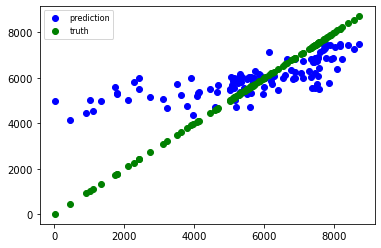

In [26]:
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

In [27]:
df_all.groupby('horizon_origin').apply(
    lambda df: pd.Series({'MAPE': MAPE(df[target_column_name], df['predicted']),
                          'RMSE': np.sqrt(mean_squared_error(df[target_column_name], df['predicted'])),
                          'MAE': mean_absolute_error(df[target_column_name], df['predicted'])}))

,MAPE,RMSE,MAE
horizon_origin,,,
1,54.16,2061.04,1721.11
2,46.51,1710.79,1201.04
3,2544.23,2062.40,1217.13
4,92.28,1954.75,1473.48
5,102.56,1514.20,1011.18
6,23.87,1254.70,907.20
7,12.72,810.49,607.27
8,41.61,1501.60,1151.00
9,40.57,1620.41,1320.31


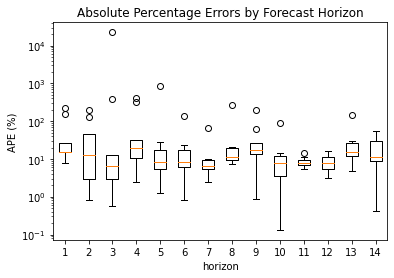

In [28]:
df_all_APE = df_all.assign(APE=APE(df_all[target_column_name], df_all['predicted']))
APEs = [df_all_APE[df_all['horizon_origin'] == h].APE.values for h in range(1, max_horizon + 1)]

%matplotlib inline
plt.boxplot(APEs)
plt.yscale('log')
plt.xlabel('horizon')
plt.ylabel('APE (%)')
plt.title('Absolute Percentage Errors by Forecast Horizon')

plt.show()

In [32]:
from azureml.train.automl.run import AutoMLRun

run_id = 'AutoML_89f7cda6-ff97-4bdb-b255-aeffd971a295'
training_run = AutoMLRun(experiment, run_id)
training_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl_bikeshare_forecast,AutoML_89f7cda6-ff97-4bdb-b255-aeffd971a295,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [33]:
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl_bikeshare_forecast,AutoML_89f7cda6-ff97-4bdb-b255-aeffd971a295_36,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [34]:

model_name = best_run.properties['model_name']
model_name

'AutoML89f7cda6f36'

In [35]:
script_file_name = 'inference/score.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'inference/score.py')

In [36]:
description = "Bike Share AutoML Model"
model = training_run.register_model(model_name = model_name,
                                    description = description,
                                    tags = None)
print(training_run.model_id)

AutoML89f7cda6f36


In [37]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

inference_config = InferenceConfig(entry_script=script_file_name, environment=best_run.get_environment())

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1,
                                               memory_gb = 1,
                                               tags = {'type': "automl-forecasting"},
                                               description = 'Sample service for AutoML Forecasting')

aci_service_name = 'automl-bike-sharing'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-bike-sharing
Running.............................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [39]:
# Requries that the bike-no-horizon.csv is uploaded to the Azure Machine Learning notebook folder
test_df = pd.read_csv('./bike-no-horizon.csv')
test_df

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,610,9/1/2012,3,1,9,6,2,0.75,0.70,0.64,0.11,2352,3788,6140
1,611,9/2/2012,3,1,9,0,2,0.70,0.65,0.81,0.06,2613,3197,5810
2,612,9/3/2012,3,1,9,1,1,0.71,0.66,0.79,0.15,1965,4069,6034
3,613,9/4/2012,3,1,9,2,1,0.73,0.69,0.76,0.24,867,5997,6864
4,614,9/5/2012,3,1,9,3,1,0.74,0.71,0.74,0.19,832,6280,7112
5,615,9/6/2012,3,1,9,4,2,0.70,0.66,0.81,0.14,611,5592,6203
6,616,9/7/2012,3,1,9,5,1,0.70,0.66,0.74,0.17,1045,6459,7504
7,617,9/8/2012,3,1,9,6,2,0.66,0.61,0.80,0.28,1557,4419,5976
8,618,9/9/2012,3,1,9,0,1,0.61,0.58,0.55,0.22,2570,5657,8227
9,619,9/10/2012,3,1,9,1,1,0.58,0.57,0.50,0.26,1118,6407,7525


In [40]:
import json
test_sample = json.dumps({'data': test_df.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
response

'{"forecast": [7155.479233632982, 5874.7084629789915, 5998.874341013738, 6246.51941832807, 6732.101406257079, 5856.813901328537, 6746.015459381452, 5292.366200844761, 6832.39579988182, 6876.008901026455, 6891.5446600609885, 7432.845441335618, 7436.408678508042, 7373.9733002822695], "index": [{"date": 1346457600000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346544000000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346630400000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346716800000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346803200000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346889600000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346976000000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "orig

In [41]:
res_dict = json.loads(response)
y_fcst_all = pd.DataFrame(res_dict['index'])
y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
y_fcst_all['forecast'] = res_dict['forecast']

In [42]:

webservice_df = pd.DataFrame({ 'Truth': test_df['cnt'], 'Forecast': y_fcst_all['forecast'] } )
webservice_df['APE'] = APE(webservice_df['Truth'], webservice_df['Forecast'])
webservice_df

,Truth,Forecast,APE
0,6140,7155.48,16.54
1,5810,5874.71,1.11
2,6034,5998.87,0.58
3,6864,6246.52,9.00
4,7112,6732.10,5.34
5,6203,5856.81,5.58
6,7504,6746.02,10.10
7,5976,5292.37,11.44
8,8227,6832.40,16.95
9,7525,6876.01,8.62
